**Final DRL project (RL in Portfolio Management)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# working directory

! pwd

/content


In [ ]:
! cd /content/drive

## Loading libraries

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 11.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
# importing libaries:

# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# modeling
import yfinance as yf # yahoo finance library
import datetime
import time
import requests
import io
import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

## Preprocessing and loading the fund data

In [ ]:
# setting the time interval for which to pull historical share prices for (5 years)
start = datetime.datetime(2018,1,1) # format: year, month, day
end = datetime.datetime(2022,12,31)

In [ ]:
# creating a list of ticker/Isin symbols 

Symbols = ["VNRT.DE","VGEU.DE","VGEJ.DE","VJPN.DE","VFEM.DE","CSHD.L"] # ticker symbols of the Vanguard ETFs for the 5 regions + lyxor overnight return money market fund

In [ ]:
# Iterating over each stock symbol and download the daily stock prices between the start and end dates using the yahoo finance API

# create empty dataframe
price_hist_df = pd.DataFrame() 
for i in Symbols:  
    
    # print the symbol which is being downloaded
    print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            price_hist_df = price_hist_df.append(stock,sort=False)
    except Exception:
        None

0 : VNRT.DE,1 : VGEU.DE,2 : VGEJ.DE,3 : VJPN.DE,4 : VFEM.DE,5 : CSHD.L,

In [ ]:
price_hist_df

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2018-01-02,56.020000,56.020000,55.070000,55.389999,55.389999,3629,VNRT.DE
2018-01-03,55.750000,55.860001,55.750000,55.860001,55.860001,350,VNRT.DE
2018-01-04,55.889999,55.970001,55.889999,55.950001,55.950001,107,VNRT.DE
2018-01-05,56.150002,56.380001,56.139999,56.380001,56.380001,375,VNRT.DE
2018-01-08,56.750000,56.799999,56.709999,56.799999,56.799999,383,VNRT.DE
...,...,...,...,...,...,...,...
2022-12-22,109.355003,109.355003,109.355003,109.235001,109.235001,2324,CSHD.L
2022-12-23,109.415001,109.415001,109.415001,109.415001,109.415001,0,CSHD.L
2022-12-28,109.900002,109.900002,109.544998,109.474998,109.474998,15,CSHD.L


In [ ]:
price_hist_df.shape

(7608, 7)

Adjusted close is the closing price after adjustments for all applicable splits and dividend distributions. Data is adjusted using appropriate split and dividend multipliers, adhering to Center for Research in Security Prices (CRSP) standards.

In [ ]:
price_hist_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000,7608.000000
mean,54.824990,54.981083,54.642839,54.811661,54.811661,13600.154048
std,34.378716,34.401261,34.357264,34.376286,34.376286,20820.649043
min,15.274000,15.624000,15.162000,15.330000,15.330000,0.000000
25%,27.055000,27.145000,26.955000,27.059999,27.059999,2118.500000
50%,37.932501,37.997499,37.867500,37.927500,37.927500,7124.500000
75%,70.602499,70.884998,70.482502,70.744999,70.744999,16812.500000
max,132.460007,132.690002,132.270004,132.449997,132.449997,341186.000000


In [ ]:
price_hist_df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64

In [ ]:
price_hist_df = price_hist_df.drop(["Open","High","Low","Adj Close","Volume"],axis=1)

price_hist_df

,Close,Name
Date,,
2018-01-02,55.389999,VNRT.DE
2018-01-03,55.860001,VNRT.DE
2018-01-04,55.950001,VNRT.DE
2018-01-05,56.380001,VNRT.DE
2018-01-08,56.799999,VNRT.DE
...,...,...
2022-12-22,109.235001,CSHD.L
2022-12-23,109.415001,CSHD.L
2022-12-28,109.474998,CSHD.L


In [ ]:
# reshaping the dataframe
prices_reshaped_df = pd.pivot_table(price_hist_df, values ='Close', index =['Date'],columns =['Name']).reset_index().ffill(axis=0) # ffill: fill NaNs with preceding values

prices_reshaped_df = prices_reshaped_df.set_index("Date") # new index


prices_reshaped_df # 4years*252 trading days = 1008 days woth of price data

Name,CSHD.L,VFEM.DE,VGEJ.DE,VGEU.DE,VJPN.DE,VNRT.DE
Date,,,,,,
2018-01-02,126.599998,52.139999,23.094999,30.660000,26.629999,55.389999
2018-01-03,127.349998,52.889999,23.309999,30.850000,27.059999,55.860001
2018-01-04,127.849998,53.139999,23.309999,31.115000,27.315001,55.950001
2018-01-05,127.459999,53.590000,23.480000,31.385000,27.410000,56.380001
2018-01-08,126.879997,53.900002,23.480000,31.500000,27.764999,56.799999
...,...,...,...,...,...,...
2022-12-23,109.415001,49.805000,23.125000,33.025002,27.264999,87.610001
2022-12-27,109.415001,50.240002,23.205000,33.064999,27.115000,87.519997
2022-12-28,109.474998,49.980000,23.055000,32.939999,27.014999,87.040001


In [ ]:
prices_reshaped_df.isna().sum() # check for NaNs

Name
CSHD.L     0
VFEM.DE    0
VGEJ.DE    0
VGEU.DE    0
VJPN.DE    0
VNRT.DE    0
dtype: int64

In [ ]:
prices_reshaped_df.columns

Index(['CSHD.L', 'VFEM.DE', 'VGEJ.DE', 'VGEU.DE', 'VJPN.DE', 'VNRT.DE'], dtype='object', name='Name')

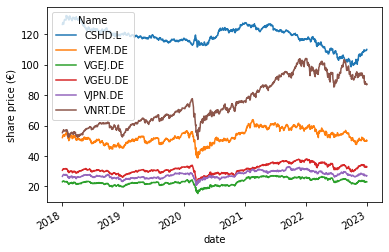

In [ ]:
prices_reshaped_df.plot()
##plt.title("historical ETF share prices")
plt.ylabel("share price (€)")
plt.xlabel("date")
plt.savefig("etf_history.png")

In [ ]:
prices_reshaped_df.to_csv("etf_history.csv") # saving the df to a csv file

In [ ]:
prices_reshaped_df.isnull().values.any() # mo missing data

False

In [ ]:
prices_reshaped_df.isnull().sum().sum()

0

Github repo zum 3 stock case blogpost
https://github.com/kvsnoufal/portfolio-optimization

Deep RL Tutorial for Portfolio Allocation

https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-portfolio-allocation-9b417660c7cd

FINRL library source: https://github.com/AI4Finance-Foundation/FinRL

In [ ]:
etf_hist_df = pd.read_csv("etf_history.csv").set_index("Date")

## normalise etf_hist_df with respect to its initial values. That way, value changes are being represented as a percentage
#etf_hist_df.iloc[:, :] = etf_hist_df.iloc[:, :] / etf_hist_df.iloc[0, :]

etf_hist_df

,CSHD.L,VFEM.DE,VGEJ.DE,VGEU.DE,VJPN.DE,VNRT.DE
Date,,,,,,
2018-01-02,126.599998,52.139999,23.094999,30.660000,26.629999,55.389999
2018-01-03,127.349998,52.889999,23.309999,30.850000,27.059999,55.860001
2018-01-04,127.849998,53.139999,23.309999,31.115000,27.315001,55.950001
2018-01-05,127.459999,53.590000,23.480000,31.385000,27.410000,56.380001
2018-01-08,126.879997,53.900002,23.480000,31.500000,27.764999,56.799999
...,...,...,...,...,...,...
2022-12-23,109.415001,49.805000,23.125000,33.025002,27.264999,87.610001
2022-12-27,109.415001,50.240002,23.205000,33.064999,27.115000,87.519997
2022-12-28,109.474998,49.980000,23.055000,32.939999,27.014999,87.040001


In [ ]:
# defining environment parameters
stock_dimension = etf_hist_df.shape[1] # no of columns

stock_dimension

6

## Building the environment

asset allocation env source: https://github.com/acbraith/gym-asset_allocation/blob/master/gym_asset_allocation/envs/asset_allocation_env.py

Custom environment to use

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding

class Environment(gym.Env):
  def __init__(self, etf_hist_df, episode_length, observation_length):
    
    self.etf_hist_df = etf_hist_df
    self.episode_length = episode_length # number of days for training
    self.observation_length = observation_length # number of days being currently observed for next decision 

    self.n = etf_hist_df.shape[1] # number of assets
    #self.total_days_in_dataset = etf_hist_df.shape[0] # total number of days in dataset

    self.observation_space = spaces.Box(0, np.inf, shape=(self.n, self.observation_length)) # observation tensor: n assets being observed for xx days
    self.action_space = spaces.Box(0, 1, shape=(self.n,))
    
    self._seed()
    self._reset()

  def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

  def _rng(self, low, high):
    return np.random.randint(low=low, high=high)       

## 1 interaction step of the agent with the environment
  def _step(self, action):
       #assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))

        if not self._get_over():
            self._take_action(action) # t is the day the asset allocation is chosen. t+1 is the day when the portfolio value has changed
            self.t += 1 # proceed to next day (time step)
        
        self.observation = self._get_observation()
        # update portfolio value
        self.reward = self._get_reward() 
        self.episode_over = self._get_over()
        self.info = {}

        
        return self.observation, self.reward, self.episode_over, self.info

## asset allocation: 6x1 array for weigths in time t
## portfolio value: PF value at time t       

  def _reset(self, episode_start=0, episode_end=30): ## reset environment (new initialization of the arrays)
    self.asset_allocation = np.zeros((self.episode_length, self.n)) # one row for each day. one column for each asset
    self.asset_allocation[0, 0] = 1 # initialise 100% of the money as cash (money market etf)
    
    self.episode_start = episode_start
    self.episode_end = episode_end
    self.t = 0 # current day within the episode. We start at day 0

    self.prices_df = etf_hist_df.iloc[episode_start:episode_end, :]

    self.portfolio_value = np.zeros((self.episode_length))
    #self.portfolio_value[0] = np.dot(self.asset_allocation[0], etf_hist_df.iloc[0,:])
    self.portfolio_value[0] = 1
    self.profitslist = [] ## list to save profits for each time step
    pass
  
  ## done flag
  def _get_over(self):
    return self.t+1 >= self.episode_length # false if another day for investment is still in episode

## normalize weight vector to length 1; 
  def _take_action(self, action):
    if action.sum() != 1 :
      action /= action.sum() # normalise action ## /= action <- action/action.sum()

    if len(action) != 6:
        raise "shapeerror"
    
    # save asset allocation in array
    self.asset_allocation[self.t] = action

    # assess current closing price vector
    self.gamma = self.prices_df.iloc[self.t+1, :] / self.prices_df.iloc[self.t, :]

    # calculate profit over night
    # dot product of asset allocation with relative value change in asset

    self.profit = np.dot(self.gamma, self.asset_allocation[self.t]) # current profit only
    self.profitslist.append(self.profit) # profit per step in a list
    self.portfolio_value[self.t+1] = self.portfolio_value[self.t] * self.profit

    pass

## get current ETF share prices
  def _get_observation(self):
    return np.array([self.etf_hist_df.iloc[self.episode_start + self.t - self.observation_length : self.episode_start + self.t, :]]) 

## change in PF value
  def _get_reward(self):
    #return (self.portfolio_value[self.t] - self.portfolio_value[self.t-1]) / self.portfolio_value[self.t-1]
    return self.profit


## Equal weight heuristic as a benchmark

In [ ]:
## environment input parameters
number_of_episodes_bm = 1
episode_length_bm = 1245 # total number of days: 1285
observation_length_bm = 40

## instantiation of the Environment class
equalw_env = Environment(etf_hist_df, episode_length_bm, observation_length_bm)



#observation : list = []
#reward : float = 0
#episode_over : bool = False
#info : dict = {}



def run_episode():
  #episode_start = env._rng(low = observation_length, high = etf_hist_df.shape[0] - episode_length) # determine start day within dataset
  episode_start = observation_length_bm
  episode_end = episode_start + episode_length_bm # determine end day with episode length
  equalw_env._reset(episode_start, episode_end)
  ##cumulative_reward = 0
  ##print("start at day: " + str(episode_start))
  for _ in range(episode_length_bm):
    
    #action = np.ones(shape = 6)
    action = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6]).astype(float) ## asset allocation weights / to test different weights
    observation, reward, episode_over, info = equalw_env._step(action)
    ##cumulative_reward += reward
    ##print(reward) ## debugging
    #print(action)
    ##print(equalw_env.portfolio_value)
  
  final_portfolio_value_bm = equalw_env.portfolio_value[equalw_env.t-1]

  #print("cum. reward after step " + str(env.t) + ": " + str(cumulative_reward))
  print("final portfolio value: " + str(final_portfolio_value_bm)) ## this is only a multiplier 



run_episode()

#

final portfolio value: 1.0904620714294655


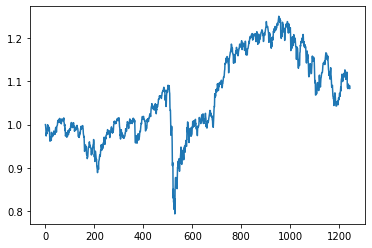

In [ ]:
plt.plot(equalw_env.portfolio_value)

FinRL API: https://finrl.readthedocs.io/en/latest/tutorial/Introduction/PortfolioAllocation.html

Multiple stock trading environment: https://finrl.readthedocs.io/en/latest/tutorial/Introduction/MultipleStockTrading.html

In [ ]:
##!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
##!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

latest FinRL tutorial: https://medium.com/analytics-vidhya/a-hitchhikers-guide-to-finrl-a-deep-reinforcement-learning-framework-for-quantitative-finance-e624c508f763

## RL theory part about actor critic algorithms

Approximated policy gradient including the learned actor function and the learned critic function: (policy weight update)
$ \Delta_{\theta} = \alpha \nabla_{\theta} log \underbrace{\pi(s,a;\theta)}_{\text{policy function of the actor}} * \underbrace{Q(s,a;w)}_{\text{Q-function of the critic}} $

pseudo code of QAC (rough summary):


*   Initialize policy and Q-function weights $\theta$, w  
Repeat for each episode:  
*   sample action from policy $\pi$
*   take action a, observe r, s'
*   sample a' acc. to policy $\pi$(s',$\cdot$,$\theta$)
*   policy weight update theta 
*   Q-function weight update w 
*   a $\leftarrow$ a', s $\leftarrow$ s'  
until s is terminal



## Implement DRL algorithm

https://theaisummer.com/Actor_critics/

**Background (actor critic policy-based algorithms):**

**actor:** The actor takes as input the state and outputs the best action. It essentially controls how the agent behaves by learning the optimal policy

**critic:** The critic, on the other hand, evaluates the action by computing the value function (value based).   
The critic which receives as an input the environment and the action by the actor, concatenates them and outputs the action value (Q-value) for the given pair (Q-value = maximum future reward)

**training:** the actor NN and the critic NN are trained separately by gradient ascent (Compute steepest uphill direction = gradient;
Take step in the gradient direction
Repeat (until held-out data accuracy starts to drop = “early stopping”))

find a global maximum and update both the policy weights theta and the value function estimate weights w

It is important to notice that *the update of the weights happen at each step (TD Learning)* and not at the end of the episode, opposed to policy gradient

**Portfolio Mgt application case:** 

input for the actor: state = portfolio value;
ouput of the actor: best action = optimal asset allocation weights

input for the critic: portfolio weights from the actor + environment i.e. the prices of the 6 assets in the portfolio at the current time step
output of the critic: Q-value (s,a) for time t


**Advantage Actor critic:**   
the advantage function A(s,a) = Q(s,a) - V(s) <-> Q(s,a) = A(s,a)+V(s) captures how much better an action is compared to other actions in a given state s

the value function V(s) captures how good it is to be in particular state ("state value function")

**modification:** the critic learns advantage-values instead of Q-values. That way the evaluation of an action is based not only on how good the action is, but also how much better it can be.

## Actor Critic in Pytorch

Actor Critic Algorithm (Pytorch)

source: https://github.com/pytorch/examples/blob/main/reinforcement_learning/actor_critic.py

Pytorch actor critic algo applied to PF Mgt: https://github.com/MatthieuSarkis/Portfolio-Optimization-and-Goal-Based-Investment-with-Reinforcement-Learning/blob/master/src/main.py

Gym is an open source Python library for developing and comparing reinforcement learning algorithms by providing a standard API to communicate between learning algorithms and environments, as well as a standard set of environments compliant with that API. Since its release, Gym's API has become the field standard for doing this.

useful repos to base our model on:  
https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/PolicyGradient/SAC/sac_torch.py

https://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py

https://github.com/kvsnoufal/portfolio-optimization/blob/main/train.py

A2C: https://github.com/mswang12/minA2C/blob/main/minA2C.py

Current to dos

1. find out why Q-value and action (state-action-pair) does not change over time within an episode --> done!

2. finetuning:

- batch normalisation
- convolutional layer
- learning rate
- activation leaky relu
- dropout
- layer size (number of neurons)
- weight initialisation xavier
- exploration/exploitation (epsilon-greedy?)

3. Benchmarking

- theory and practice

4. experiments and conclusion

mini CNN classification net architecture:



```
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10,
                               kernel_size=5,
                               stride=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.dense1 = nn.Linear(in_features=320, out_features=50)
        self.dense1_bn = nn.BatchNorm1d(50)
        self.dense2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), 2))
        x = x.view(-1, 320) #reshape
        x = F.relu(self.dense1_bn(self.dense1(x)))
        x = F.relu(self.dense2(x))
        return F.log_softmax(x)
```





```
# nn.Sequential version of the current actor NN with batchnorm

p=0.2

model = nn.Sequential(nn.Linear(self.state_size + self.action_size, 100), # use convolutional layers
                      nn.BatchNorm1d(100), # test (always apply BN before the non-linearity; faster convergence, higher LR possible)
                      nn.ReLU(),
                      nn.Dropout(p),
                      nn.Linear(100, 20),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(20, self.action_size), # 6 output neurons  for the 6 positions
                      torch.sigmoid(),
                    ##  torch.mul(distribution, 1/torch.sum(distribution))
                     )


```




In [ ]:
# standard deviations
from operator import add, sub
import math

def stdev(data):
    var = variance(data)
    std_dev = math.sqrt(var)
    return std_dev

def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)



In [ ]:
## defining a leaky ReLU activation function
from torch.nn import LeakyReLU
m = nn.LeakyReLU(0.1) # negative slope: 0.1

6
240
episode: 0, final portfolio value: 1.1586395965375795
final action: [0.26337851 0.00123122 0.00566124 0.26768134 0.19456197 0.26748572]
episode: 1, final portfolio value: 1.1544463796810311
final action: [0.24715566 0.00090984 0.00495039 0.25453728 0.23804828 0.25439855]
episode: 2, final portfolio value: 1.1504504227663825
final action: [0.24095307 0.00087207 0.00809943 0.25334508 0.24361704 0.25311331]
episode: 3, final portfolio value: 1.1452998221101007
final action: [0.24542875 0.00056752 0.00636822 0.25436347 0.23917067 0.25410136]
episode: 4, final portfolio value: 1.1565666773867203
final action: [0.24805524 0.00036948 0.00241748 0.26203796 0.2254534  0.26166644]
episode: 5, final portfolio value: 1.1740000068542646
final action: [2.62078615e-01 2.51831081e-04 9.39702623e-04 2.82903942e-01
 1.71572254e-01 2.82253655e-01]
episode: 6, final portfolio value: 1.192499720810709
final action: [2.79767277e-01 1.47682020e-04 5.31294386e-04 3.18343110e-01
 8.48889597e-02 3.1632167

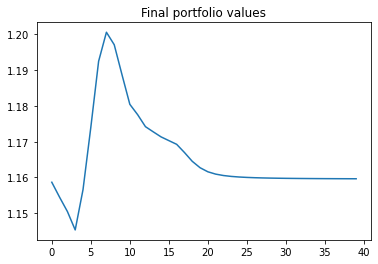

In [ ]:

## Actor Critic RL model

import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical


#device = "cuda"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number_of_experiments = 1 # 1 experiment = xx episodes. New experiment = new initialised neural networks

## environment input parameters
number_of_episodes = 40
episode_length = 1245 # total number of days: 1285
observation_length = 40

## hyperparameters ##

n_iters = number_of_episodes ## no. of episodes
lr = 0.0001 ## learning rate (initially at lr = 0.0001)
gamma = 0.98  ## discount rate


## inputs for the actor critic algorithm ##

#env = pf_env  ## PF environment
##env = gym.make("CartPole-v0").unwrapped
##state_size = pf_env.observation_space.shape[1]
action_size = etf_hist_df.shape[1] # 6
state_size = observation_length * etf_hist_df.shape[1] ## currently 240 = 40*6

env = Environment(etf_hist_df, episode_length, observation_length) #initialize environment

print(action_size), print(state_size) ## debugging
##rewards = pf_env.reward  ## to do: can't access _get_reward method from environment


## actor learns the best action in a given state; input: state i.e. actor lears a policy (state-action mapping)
## theta: parametrized policy weights
class Actor(nn.Module): 
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 200)
        ##self.bnlinear1 = nn.Sequential(nn.Linear(self.state_size, 100), ## addon (permits higher LR + less careful init)
        ##                               nn.BatchNorm1d(100),
        ##                               nn.ReLU()
        ##                               ) 
        self.linear2 = nn.Linear(200, 20)
        self.bn = nn.BatchNorm1d(20) ## addon 
        self.dropout = nn.Dropout(0.2) ## addon (regularization; dropout pr 0.2)
        self.linear3 = nn.Linear(20, self.action_size)

    def forward(self, state):
        ##output = F.relu(self.linear1(state))
        output = m(self.linear1(state))
        ##output = self.bnlinear1(state) ## change attempt
        ##output = F.relu(self.linear2(output))
        output = m(self.linear2(output))
        ##output = self.bn(self.linear2(output.view(-1,20)))    ## change
        ##output = F.relu(output) ## change
        ##output = self.dropout(output) ## change
        output = self.linear3(output)
        #distribution = Categorical(F.softmax(output, dim=-1))
        #distribution = F.softmax(output, dim=-1)
        distribution = torch.sigmoid(output)#.detach().numpy().astype(float)
        distribution = torch.mul(distribution, 1/torch.sum(distribution)) # normalise array so that sum = 1
        return distribution #distribution

## new actor class with nn.Sequential()
#class Actor(nn.Module): 
#    def __init__(self, state_size, action_size):
#         super(Actor, self).__init__()
#         self.state_size = state_size
#         self.action_size = action_size
#         self.net = nn.Sequential(nn.Linear(self.state_size, 100), # use convolutional layers
#                      nn.BatchNorm1d(100), # test (always apply BN before the non-linearity; faster convergence, higher LR possible)
#                      nn.ReLU(),
#                      nn.Dropout(0.2),
#                      nn.Linear(100, 20),
#                      nn.ReLU(),
#                      nn.Dropout(0.2),
#                      nn.Linear(20, self.action_size), # 6 output neurons  for the 6 positions
#                   
#                     )
#             
#    def forward(self, state_size):
#        x = self.net(state_size)
#        distribution = torch.sigmoid(x)#.detach().numpy().astype(float)
#        distribution = torch.mul(distribution, 1/torch.sum(distribution)) # normalise array so that sum = 1
#        return distribution #distribution
        

## critic evaluates action by learning Q-value Q(s,a) or Advantage-value A(s,a) ; input: action (weights), environment (current prices)
## value function estimate weights w
class Critic(nn.Module): 
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size + self.action_size, 200)
        self.linear2 = nn.Linear(200, 10)
        self.dropout = nn.Dropout(0.2) ## addon (regularization; dropout pr 0.2)
        self.linear3 = nn.Linear(10, 1)

    def forward(self, state_action_pair):
        ##output = F.relu(self.linear1(state_action_pair))
        output = m(self.linear1(state_action_pair))
        ##output = F.relu(self.linear2(output))
        output = m(self.linear2(output))
        #output = self.dropout(output) ## change
        value = self.linear3(output)
        return value


def compute_returns(next_value, rewards, masks, gamma=0.99): ## to do: use rewards defined in the PF environment
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step] ## masks?
        returns.insert(0, R)
    return returns

def prepare_state(state, input_shape): ## added by Marc
  # this needs a numpy array as input to work
  state = torch.Tensor(state.astype(float))
  state = state.reshape([1, input_shape]) 
  return state



## AGENT ##

# CNN architectures

##def trainIters(CNN_Actor, CNN_Critic, n_iters):
##    optimizerA = optim.Adam(CNN_Actor.parameters(), lr=lr) # optimization algorithm (ADAM) for the actor NN
##    optimizerC = optim.Adam(CNN_Critic.parameters(), lr=lr) # optimization algorithm (ADAM) for the critic NN

# feedwordward architectures

def trainIters(actor, critic, n_iters):
    optimizerA = optim.Adam(actor.parameters(), lr=lr) # optimization algorithm (ADAM) for the actor NN
    optimizerC = optim.Adam(critic.parameters(), lr=lr) # optimization algorithm (ADAM) for the critic NN
    
    final_portfolio_values = []

    mean_profits_episode = []

    std_profits_episode = []

# loop over the total number of episodes
    
    for iter in range(n_iters):
        #episode_start = env._rng(low = observation_length, high = etf_hist_df.shape[0] - episode_length) # determine start day within dataset
        episode_start = observation_length
        episode_end = episode_start + episode_length # determine end day with episode length
        env._reset(episode_start, episode_end)
        
        #state = env._reset() ## here the current PF value (=state) should be inserted
        state = etf_hist_df.iloc[episode_start - observation_length : episode_start, :].to_numpy()
        action = env.asset_allocation[0, :]
        state_action_pair = np.append(state, action)
        
        state = prepare_state(state, state_size) ## added by Marc
        state_action_pair = prepare_state(state_action_pair, state_size + action_size)
        

        log_probs = []
        values = []
        rewards = [] ## reward = change in PF value
        masks = []
        entropy = 0
        #env.reset()
        
    
        

## main loop trough one episode
        for i in range(episode_length):
            ##env.render() ## not implemented
            #print(state) ## debugging
            #state = torch.FloatTensor(state).to(device) ## state contains none object -> issue
            dist, value = actor(state), critic(state_action_pair)
            #print(value)
            #print("Q-value: " + value.detach().numpy().astype(float))

            #action = dist.sample(sample_shape=torch.Size([6]))
            action = dist.detach().numpy().astype(float)[0]
            dist = Categorical(dist)
            
            next_state, reward, done, _ = env._step(action) ## rewards?
            next_state = prepare_state(next_state, state_size)

            #torch.as_tensor(action)
            log_prob = dist.log_prob(dist.sample()).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            
            rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
            masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

            if done:
                print("episode: " + str(iter) + ", final portfolio value: " + str(env.portfolio_value[env.t]))
                print("final action: " + str(action))
                ##print("episode: " + str(iter) + "mean_episode return" + str(mean_profits_episode) )
                
                #print('Episode: {}, Step within episode: {}'.format(iter, i))
                final_portfolio_values.append(env.portfolio_value[env.t]) # PF value to plot -> To Do. compute by episode

                ##mean_profits_episode.append(np.mean(env.profitslist))
                ##print(mean_profits_episode) 

                ##std_profits_episode.append(round(stdev(env.profitslist),4))
                ##print(std_profits_episode)

                # addition/subtraction of list elements (elementwise)
                ##std_up_mnb = list( map(add, mean_profits_episode, std_profits_episode) )
                ##std_down_mnb = list( map(sub, mean_profits_episode, std_profits_episode) )
                # syntax: fill_between(x,y1,y2,...)
        
                
                break

            # prepare next state action pair for critic
            action_tensor = torch.FloatTensor(action).to(device).reshape([1, action_size])
            next_state_action_pair = torch.cat((next_state, action_tensor), dim=1)

            state = next_state
            state_action_pair = next_state_action_pair

            next_state = torch.FloatTensor(next_state).to(device)
            next_state = next_state.reshape([1, state_size])

            
        
        # at every end of an episode
        next_value = critic(next_state_action_pair)
        returns = compute_returns(next_value, rewards, masks,gamma=gamma)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values ## advantage function definition

        actor_loss = -(log_probs * advantage.detach()).mean()  ## actor loss to learn policy (policy gradient*Advantage estimate); gradient ascent (min of a neg. function)
        critic_loss = advantage.pow(2).mean() ## critic loss to learn Q-value/Advantayge value (Advantage estimate)

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()
    #torch.save(actor, 'model/actor.pkl') ## saving the models to pickle
    #torch.save(critic, 'model/critic.pkl')
    #env.close()




        

        if iter == n_iters-1: # 

          plt.plot(final_portfolio_values)
          plt.title("Final portfolio values")
          plt.savefig("final_portfolio_values.png")

          # plotting the mean profits with a stddev band
          ##plt.plot(mean_profits_episode)
          #plt.fill_between(mean_profits_episode, std_up_mnb, std_down_mnb, color='C0', alpha=0.5)
          
          #plt.title("Mean profits episode")
          ##plt.xlabel('Percentage of all features included (in %)')
          ##plt.ylabel('Predictive model accuracy')
          ##plt.savefig("mean_profits_episode_with_stddev.png")
          
## TO DO: plot mean rewards per episode with std.dev. bands          

if __name__ == '__main__':

    for experiment_number in range(number_of_experiments):
      if os.path.exists('model/actor.pkl'):
          actor = torch.load('model/actor.pkl')
          print('Actor Model loaded')
      else:
          actor = Actor(state_size, action_size).to(device)
      if os.path.exists('model/critic.pkl'):
          critic = torch.load('model/critic.pkl')
          print('Critic Model loaded')
      else:
          critic = Critic(state_size, action_size).to(device)

      trainIters(actor, critic, n_iters)


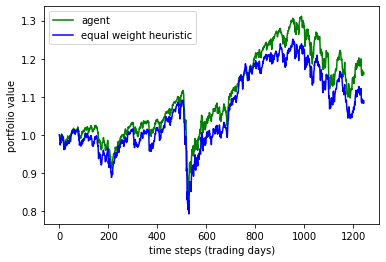

In [ ]:
# plot vs benchmark
plt.plot(env.portfolio_value, color="green",label='agent')
plt.plot(equalw_env.portfolio_value, color="blue", label='equal weight heuristic')
##plt.title("agent vs benchmark heuristic")
plt.legend()
plt.ylabel("portfolio value")
plt.xlabel("time steps (trading days)")
plt.savefig("agent_vs_benchmark.png")

CNN actor critic

In [ ]:
## CNN actor and critic architecture

class CNN_Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(CNN_Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.conv1 = nn.Conv2d(in_channels=self.state_size, out_channels=10,
                               kernel_size=5,
                               stride=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.dense1 = nn.Linear(in_features=320, out_features=50)
        self.dense1_bn = nn.BatchNorm1d(50)
        self.dense2 = nn.Linear(50, self.action_size)

    def forward(self, x):
        x = m(F.max_pool2d(self.conv1(x), 2))
        x = m(F.max_pool2d(self.conv2_bn(self.conv2(x)), 2))
        x = x.view(-1, 320) #reshape
        x = m(self.dense1_bn(self.dense1(x)))
        x = m(self.dense2(x))
        distribution = torch.sigmoid(x)#.detach().numpy().astype(float)
        distribution = torch.mul(distribution, 1/torch.sum(distribution)) # normalise array so that sum = 1
        return distribution #distribution



class CNN_Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(CNN_Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.conv1 = nn.Conv2d(in_channels=self.state_size + self.action_size, out_channels=10,
                               kernel_size=5,
                               stride=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(20)
        self.dense1 = nn.Linear(in_features=320, out_features=50)
        self.dense1_bn = nn.BatchNorm1d(50)
        self.dense2 = nn.Linear(50, self.action_size)

    def forward(self, state_action_pair):
        x = m(F.max_pool2d(self.conv1(state_action_pair), 2))
        x = m(F.max_pool2d(self.conv2_bn(self.conv2(x)), 2))
        x = x.view(-1, 320) #reshape
        x = m(self.dense1_bn(self.dense1(x)))
        value = m(self.dense2(x))
        return value




6
240
episode: 0, final portfolio value: 0.9797568446035346
final action: [0.28844838 0.2935247  0.06501893 0.13770308 0.21489803 0.00040689]
episode: 1, final portfolio value: 0.9893052180648394
final action: [2.82311293e-01 2.84410956e-01 5.60431150e-02 2.39216181e-01
 1.37876959e-01 1.41496611e-04]
episode: 2, final portfolio value: 0.9923680991002687
final action: [2.89344274e-01 2.91124337e-01 4.25098454e-02 2.82218598e-01
 9.47310753e-02 7.18702195e-05]
episode: 3, final portfolio value: 0.993170668495606
final action: [2.93091882e-01 2.94778217e-01 3.75177549e-02 2.95173813e-01
 7.93903818e-02 4.79525036e-05]
episode: 4, final portfolio value: 0.9963147808672118
final action: [2.90050683e-01 2.99403784e-01 2.11480556e-02 3.02754995e-01
 8.66049297e-02 3.75525921e-05]
episode: 5, final portfolio value: 1.0028451868163335
final action: [2.70854295e-01 3.00399394e-01 1.17461905e-02 3.03339542e-01
 1.13623128e-01 3.74509474e-05]
episode: 6, final portfolio value: 1.008627866239088
f

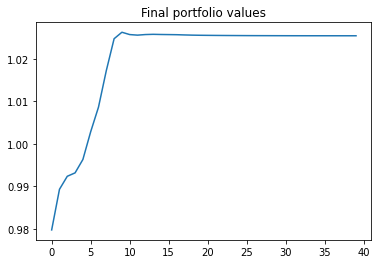

In [ ]:

## CNN Actor Critic RL model

import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical


#device = "cuda"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

number_of_experiments = 1 # 1 experiment = xx episodes. New experiment = new initialised neural networks

## environment input parameters
number_of_episodes = 40
episode_length = 1245 # total number of days: 1285
observation_length = 40

## hyperparameters ##

n_iters = number_of_episodes ## no. of episodes
lr = 0.0001 ## learning rate (initially at lr = 0.0001)
gamma = 0.98  ## discount rate


## inputs for the actor critic algorithm ##

#env = pf_env  ## PF environment
##env = gym.make("CartPole-v0").unwrapped
##state_size = pf_env.observation_space.shape[1]
action_size = etf_hist_df.shape[1] # 6
state_size = observation_length * etf_hist_df.shape[1] ## currently 240 = 40*6

env = Environment(etf_hist_df, episode_length, observation_length) #initialize environment

print(action_size), print(state_size) ## debugging
##rewards = pf_env.reward  ## to do: can't access _get_reward method from environment


## actor learns the best action in a given state; input: state i.e. actor lears a policy (state-action mapping)
## theta: parametrized policy weights
class Actor(nn.Module): 
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 200)
        ##self.bnlinear1 = nn.Sequential(nn.Linear(self.state_size, 100), ## addon (permits higher LR + less careful init)
        ##                               nn.BatchNorm1d(100),
        ##                               nn.ReLU()
        ##                               ) 
        self.linear2 = nn.Linear(200, 20)
        self.bn = nn.BatchNorm1d(20) ## addon 
        self.dropout = nn.Dropout(0.2) ## addon (regularization; dropout pr 0.2)
        self.linear3 = nn.Linear(20, self.action_size)

    def forward(self, state):
        ##output = F.relu(self.linear1(state))
        output = m(self.linear1(state))
        ##output = self.bnlinear1(state) ## change attempt
        ##output = F.relu(self.linear2(output))
        output = m(self.linear2(output))
        ##output = self.bn(self.linear2(output.view(-1,20)))    ## change
        ##output = F.relu(output) ## change
        ##output = self.dropout(output) ## change
        output = self.linear3(output)
        #distribution = Categorical(F.softmax(output, dim=-1))
        #distribution = F.softmax(output, dim=-1)
        distribution = torch.sigmoid(output)#.detach().numpy().astype(float)
        distribution = torch.mul(distribution, 1/torch.sum(distribution)) # normalise array so that sum = 1
        return distribution #distribution

## new actor class with nn.Sequential()
#class Actor(nn.Module): 
#    def __init__(self, state_size, action_size):
#         super(Actor, self).__init__()
#         self.state_size = state_size
#         self.action_size = action_size
#         self.net = nn.Sequential(nn.Linear(self.state_size, 100), # use convolutional layers
#                      nn.BatchNorm1d(100), # test (always apply BN before the non-linearity; faster convergence, higher LR possible)
#                      nn.ReLU(),
#                      nn.Dropout(0.2),
#                      nn.Linear(100, 20),
#                      nn.ReLU(),
#                      nn.Dropout(0.2),
#                      nn.Linear(20, self.action_size), # 6 output neurons  for the 6 positions
#                   
#                     )
#             
#    def forward(self, state_size):
#        x = self.net(state_size)
#        distribution = torch.sigmoid(x)#.detach().numpy().astype(float)
#        distribution = torch.mul(distribution, 1/torch.sum(distribution)) # normalise array so that sum = 1
#        return distribution #distribution
        

## critic evaluates action by learning Q-value Q(s,a) or Advantage-value A(s,a) ; input: action (weights), environment (current prices)
## value function estimate weights w
class Critic(nn.Module): 
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size + self.action_size, 200)
        self.linear2 = nn.Linear(200, 10)
        self.dropout = nn.Dropout(0.2) ## addon (regularization; dropout pr 0.2)
        self.linear3 = nn.Linear(10, 1)

    def forward(self, state_action_pair):
        ##output = F.relu(self.linear1(state_action_pair))
        output = m(self.linear1(state_action_pair))
        ##output = F.relu(self.linear2(output))
        output = m(self.linear2(output))
        #output = self.dropout(output) ## change
        value = self.linear3(output)
        return value


def compute_returns(next_value, rewards, masks, gamma=0.99): ## to do: use rewards defined in the PF environment
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step] ## masks?
        returns.insert(0, R)
    return returns

def prepare_state(state, input_shape): ## added by Marc
  # this needs a numpy array as input to work
  state = torch.Tensor(state.astype(float))
  state = state.reshape([1, input_shape]) 
  return state



## AGENT ##

# CNN architectures

def trainIters(CNN_Actor, CNN_Critic, n_iters):
    optimizerA = optim.Adam(CNN_Actor.parameters(), lr=lr) # optimization algorithm (ADAM) for the actor NN
    optimizerC = optim.Adam(CNN_Critic.parameters(), lr=lr) # optimization algorithm (ADAM) for the critic NN

# feedwordward architectures

##def trainIters(actor, critic, n_iters):
##    optimizerA = optim.Adam(actor.parameters(), lr=lr) # optimization algorithm (ADAM) for the actor NN
##    optimizerC = optim.Adam(critic.parameters(), lr=lr) # optimization algorithm (ADAM) for the critic NN
    
    final_portfolio_values = []

    mean_profits_episode = []

    std_profits_episode = []

# loop over the total number of episodes
    
    for iter in range(n_iters):
        #episode_start = env._rng(low = observation_length, high = etf_hist_df.shape[0] - episode_length) # determine start day within dataset
        episode_start = observation_length
        episode_end = episode_start + episode_length # determine end day with episode length
        env._reset(episode_start, episode_end)
        
        #state = env._reset() ## here the current PF value (=state) should be inserted
        state = etf_hist_df.iloc[episode_start - observation_length : episode_start, :].to_numpy()
        action = env.asset_allocation[0, :]
        state_action_pair = np.append(state, action)
        
        state = prepare_state(state, state_size) ## added by Marc
        state_action_pair = prepare_state(state_action_pair, state_size + action_size)
        

        log_probs = []
        values = []
        rewards = [] ## reward = change in PF value
        masks = []
        entropy = 0
        #env.reset()
        
    
        

## main loop trough one episode
        for i in range(episode_length):
            ##env.render() ## not implemented
            #print(state) ## debugging
            #state = torch.FloatTensor(state).to(device) ## state contains none object -> issue
            dist, value = actor(state), critic(state_action_pair)
            #print(value)
            #print("Q-value: " + value.detach().numpy().astype(float))

            #action = dist.sample(sample_shape=torch.Size([6]))
            action = dist.detach().numpy().astype(float)[0]
            dist = Categorical(dist)
            
            next_state, reward, done, _ = env._step(action) ## rewards?
            next_state = prepare_state(next_state, state_size)

            #torch.as_tensor(action)
            log_prob = dist.log_prob(dist.sample()).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            
            rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
            masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

            if done:
                print("episode: " + str(iter) + ", final portfolio value: " + str(env.portfolio_value[env.t]))
                print("final action: " + str(action))
                ##print("episode: " + str(iter) + "mean_episode return" + str(mean_profits_episode) )
                
                #print('Episode: {}, Step within episode: {}'.format(iter, i))
                final_portfolio_values.append(env.portfolio_value[env.t]) # PF value to plot -> To Do. compute by episode

                ##mean_profits_episode.append(np.mean(env.profitslist))
                ##print(mean_profits_episode) 

                ##std_profits_episode.append(round(stdev(env.profitslist),4))
                ##print(std_profits_episode)

                # addition/subtraction of list elements (elementwise)
                ##std_up_mnb = list( map(add, mean_profits_episode, std_profits_episode) )
                ##std_down_mnb = list( map(sub, mean_profits_episode, std_profits_episode) )
                # syntax: fill_between(x,y1,y2,...)
        
                
                break

            # prepare next state action pair for critic
            action_tensor = torch.FloatTensor(action).to(device).reshape([1, action_size])
            next_state_action_pair = torch.cat((next_state, action_tensor), dim=1)

            state = next_state
            state_action_pair = next_state_action_pair

            next_state = torch.FloatTensor(next_state).to(device)
            next_state = next_state.reshape([1, state_size])

            
        
        # at every end of an episode
        next_value = critic(next_state_action_pair)
        returns = compute_returns(next_value, rewards, masks,gamma=gamma)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values ## advantage function definition

        actor_loss = -(log_probs * advantage.detach()).mean()  ## actor loss to learn policy (policy gradient*Advantage estimate); gradient ascent (min of a neg. function)
        critic_loss = advantage.pow(2).mean() ## critic loss to learn Q-value/Advantayge value (Advantage estimate)

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()
    #torch.save(actor, 'model/actor.pkl') ## saving the models to pickle
    #torch.save(critic, 'model/critic.pkl')
    #env.close()




        

        if iter == n_iters-1: # 

          plt.plot(final_portfolio_values)
          plt.title("Final portfolio values")
          plt.savefig("final_portfolio_values.png")

          # plotting the mean profits with a stddev band
          ##plt.plot(mean_profits_episode)
          #plt.fill_between(mean_profits_episode, std_up_mnb, std_down_mnb, color='C0', alpha=0.5)
          
          #plt.title("Mean profits episode")
          ##plt.xlabel('Percentage of all features included (in %)')
          ##plt.ylabel('Predictive model accuracy')
          ##plt.savefig("mean_profits_episode_with_stddev.png")
          
## TO DO: plot mean rewards per episode with std.dev. bands          

if __name__ == '__main__':

    for experiment_number in range(number_of_experiments):
      if os.path.exists('model/actor.pkl'):
          actor = torch.load('model/actor.pkl')
          print('Actor Model loaded')
      else:
          actor = Actor(state_size, action_size).to(device)
      if os.path.exists('model/critic.pkl'):
          critic = torch.load('model/critic.pkl')
          print('Critic Model loaded')
      else:
          critic = Critic(state_size, action_size).to(device)

      trainIters(actor, critic, n_iters)


## Performance evaluation

possible benchmarks:


*   Market cap
*   GDP weights
*   equal weight (regions, sectors)




possible metrics computed on the series of PF values (remember: reward = PF value)


*   Sharpe ratio (excess return/std of the PF Value)
*   Max drawdown (max decrease over the time frame considered)
*   PF volatility (sqrt of the estimated PF matrix of the single stock returns)



sharpe ratio

In [ ]:
## sharpe ratio (daily returns)
Sharpe_Ratio = portf_val[‘Daily Return’].mean() / portf_val[‘Daily Return’].std()

## annulalization
sharpe_ratio_pa = np.sqrt(252)*Sharpe_Ratio ## 252 trading days in a year



In [ ]:
# risk free rate
v = etf_hist_df["CSHD.L"]

v

Date
2018-01-02    126.599998
2018-01-03    127.349998
2018-01-04    127.849998
2018-01-05    127.459999
2018-01-08    126.879997
                 ...    
2022-12-23    109.415001
2022-12-27    109.415001
2022-12-28    109.474998
2022-12-29    109.974998
2022-12-30    110.144997
Name: CSHD.L, Length: 1285, dtype: float64

In [ ]:
( ( (v.iloc[-1]-v.iloc[0])/v.iloc[0] )  )

-0.12997631934741558

In [ ]:
# sharpe ratio agent
Sharpe_Ratio = (env.portfolio_value[-1]-1 - ( ( (v.iloc[-1]-v.iloc[0])/v.iloc[0] )  ) ) / np.std(env.portfolio_value)

Sharpe_Ratio

2.7204708403843694

In [ ]:
# sharpe ratio equal weight bm
Sharpe_Ratio_bm = (equalw_env.portfolio_value[-1]-1 - ( ( (v.iloc[-1]-v.iloc[0])/v.iloc[0] )  ) ) / np.std(equalw_env.portfolio_value)

Sharpe_Ratio_bm

2.1916435968453425

annualized volatility

In [ ]:
env.profitslistnp.std([0:256])

0.005310800992318869

In [ ]:
# vola annualized
np.sqrt(252)*np.std(env.profitslist)

0.1196361554786945

In [ ]:
# vola annulized bm
np.sqrt(252)*np.std(equalw_env.profitslist)

0.14124384439599227

cumulative return over the 5 year period

In [ ]:
# cum ret.
env.portfolio_value[-1]

1.1596164442769141

In [ ]:
# cum ret. bm
equalw_env.portfolio_value[-1]

1.0842290942751431

mean return per annum

In [ ]:
# mean ret. p.a. = [(daily return+1)^365 - 1]*100%

mean_ret_pa = (np.mean(env.profitslist)**365) -1

mean_ret_pa

0.05533038934324064

In [ ]:
mean_ret_pa_bm = (np.mean(equalw_env.profitslist)**365) -1

mean_ret_pa_bm

0.039011935807406806